In [2]:
using ITensors
using ITensorMPS
using Plots
using LaTeXStrings

Let's start with Exact Diagonalization

In [3]:
# Matrix representations for local operators and states:

X = [0 1; 1 0]
Y = [0 -1im; 1im 0]
Z = [1 0; 0 -1]
Identity = [1 0; 0 1]; #or Using LinearAlgebra and Matrix{Float64}(I, 2, 2)

zero = [1; 0] #↑ = [1; 0]
one = [0; 1] #↓ = [0; 1]

#Note: These functions build all the operators multiplying ⊗ at the right. The basis and everything should follow this convention.

function Enlarge_Matrix_site_j(N, j, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix)) #In case that Identity have not been defined globally before.
    for i=1:size(matrix)[1]; Identity[i,i] = 1; end  
    
    M = Identity
    j == 1 ? M = matrix : nothing
    
    for i=2:N 
        i == j ? M = kron(M, matrix) :  M = kron(M, Identity)        
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(N, i, j, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i)) #In case that Identity have not been defined globally before.
    for i=1:size(matrix_i)[1]; Identity[i,i] = 1; end 

    M = Identity

    j == 1 ? M = matrix_j : nothing
    i == 1 ? M = matrix_i : nothing
 
    for k=2:N 
        if k == j
            M = kron(M, matrix_j)
        elseif k == i
            M = kron(M, matrix_i)
        else
            M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

In [4]:
N = 10
J = 1.0
α = 1.0

function Build_H_Exact(N, J, α)

    H = zeros(2^(N), 2^(N))

    for j=1:N
        for i =1:j-1
            H += J*exp(-α*abs(i-j))*(Enlarge_Matrix_i_Matrix_j(N,i,j,X,X) + Enlarge_Matrix_i_Matrix_j(N,i,j,Y,Y))
        end
    end
    
    return H
end

function Build_H_MPO(sites, J, α)

    N = length(sites)

    os = OpSum()

    for j=1:N
        for i =1:j-1
            os += J*exp(-α*abs(i-j)), "X", i, "X", j
            os += J*exp(-α*abs(i-j)), "Y", i, "Y", j
        end
    end

    H = MPO(os, sites);   
    return H
end

Build_H_MPO (generic function with 1 method)

In [5]:
H_ED = Build_H_Exact(N, J, α);

In [6]:
eigvals, eigvecs = eigen(H_ED)
@show eigvals[1]

eigvals[1] = -3.862229651875292


-3.862229651875292

In [7]:
sites = siteinds("Qubit", N)

@show op("X", sites[1])
@show op("Y", sites[1])

H_MPO = Build_H_MPO(sites, J, α);

op("X", sites[1]) = ITensor ord=2
Dim 1: (dim=2|id=412|"Qubit,Site,n=1")'
Dim 2: (dim=2|id=412|"Qubit,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.0  1.0
 1.0  0.0
op("Y", sites[1]) = ITensor ord=2
Dim 1: (dim=2|id=412|"Qubit,Site,n=1")'
Dim 2: (dim=2|id=412|"Qubit,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.0 + 0.0im  -0.0 - 1.0im
 0.0 + 1.0im   0.0 + 0.0im


In [8]:
Ψ0 = random_mps(sites)
E, Ψ = dmrg(H_MPO,Ψ0; nsweeps = 100, maxdim = 40, cutoff = 10e-10);

After sweep 1 energy=-3.8484253271571762  maxlinkdim=4 maxerr=1.22E-15 time=13.277
After sweep 2 energy=-3.862227748004495  maxlinkdim=16 maxerr=9.03E-10 time=0.025
After sweep 3 energy=-3.862229650758052  maxlinkdim=16 maxerr=6.39E-10 time=0.031
After sweep 4 energy=-3.862229650782195  maxlinkdim=16 maxerr=2.61E-10 time=0.029
After sweep 5 energy=-3.862229650782205  maxlinkdim=16 maxerr=2.61E-10 time=0.041
After sweep 6 energy=-3.8622296507822047  maxlinkdim=16 maxerr=2.61E-10 time=0.020
After sweep 7 energy=-3.8622296507822043  maxlinkdim=16 maxerr=2.61E-10 time=0.019
After sweep 8 energy=-3.862229650782204  maxlinkdim=16 maxerr=2.61E-10 time=0.042
After sweep 9 energy=-3.8622296507822  maxlinkdim=16 maxerr=2.61E-10 time=0.034
After sweep 10 energy=-3.8622296507822047  maxlinkdim=16 maxerr=2.61E-10 time=0.020
After sweep 11 energy=-3.8622296507822025  maxlinkdim=16 maxerr=2.61E-10 time=0.023
After sweep 12 energy=-3.8622296507822123  maxlinkdim=16 maxerr=2.61E-10 time=0.023
After swe

We got the same ground state, then the MPO is well defined and agrees with the exact diagonalization results. Now we can start thinking about time evolution.

- **Exact Time Evolution**

- **Time dependent variational principle (TDVP)**

- **Time Evolving Block Decimation (TEBD)**

- **Article method with $W_{I}$ MPO**

In [9]:
function Time_Evolution_Op_Exact(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>
    return U = exp(-1im*t*H)   
end

Time_Evolution_Op_Exact (generic function with 1 method)

Clearly we need some observable to benchmark the time evolution.

In [10]:
function CorrelationsXiXj_FromCenter_Exact(N, Ψ)

    Distance_ij = []
    Correlations = []
    
    Center = round(N/2)
    i = Center 
    j = Center
        
    for k = 1:N-1
        Center = round(N/2) #i,j must take values moving since the center in order to avoid edge effects.
        if k % 2 != 0
            i = i 
            j = j + 1
        else
            i = i - 1
            j = j 
        end    
        # @show (i,j)
        
        Operator_ij = Enlarge_Matrix_i_Matrix_j(N, i, j, X, X)
        Correlation = adjoint(Ψ)*Operator_ij*Ψ
    
        append!(Distance_ij, abs(i-j)) #x
        append!(Correlations, Correlation) #y
    end
    
    return Correlations, Distance_ij
end

function CorrelationsXiXj_FromCenter_TensorNetworks(Ψ)

    sites = siteinds(Ψ)
    N = length(sites)
    
    Distance_ij = []
    Correlations = []
    
    Center = Int(round(N/2))
    i = Center 
    j = Center
        
    for k = 1:N-1
        Center = round(N/2) #i,j must take values moving since the center in order to avoid edge effects.
        if k % 2 != 0
            i = i 
            j = j + 1
        else
            i = i - 1
            j = j 
        end    
        # @show (i,j)
        
        Operator_ij = op("X", sites[i])*op("X", sites[j])
        Correlation = inner(Ψ, apply(Operator_ij, Ψ))       
    
        append!(Distance_ij, abs(i-j)) #x
        append!(Correlations, Correlation) #y
    end
    
    return Correlations, Distance_ij
end

CorrelationsXiXj_FromCenter_TensorNetworks (generic function with 1 method)

In [11]:
GS_ED = eigvecs[:, 1]
Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, GS_ED)

(Any[-0.8542459777549816 + 0.0im, 0.2665141033646302 + 0.0im, -0.14322325824487359 + 0.0im, 0.15215618273719184 + 0.0im, -0.17133655999016886 + 0.0im, 0.08638962846568839 + 0.0im, -0.04456352791915866 + 0.0im, 0.05427746316177418 + 0.0im, -0.06645444370666406 + 0.0im], Any[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

In [12]:
GS_MPS = Ψ #from DMRG
Correlations_TN, Distance_ij_TN = CorrelationsXiXj_FromCenter_TensorNetworks(GS_MPS)

(Any[-0.8542459744570086 + 2.083072032578794e-16im, 0.26651409600919723 - 5.977254260540096e-17im, -0.14322309834342653 + 9.67702602334217e-17im, 0.15215568705475183 - 9.108204235403606e-17im, -0.17133412522238792 + 3.9263884890978535e-17im, 0.08638667751691827 - 2.4191318786638974e-16im, -0.044558847951631134 + 1.7739408378522746e-16im, 0.05427508425108177 - 2.7254424820283904e-16im, -0.06645300963177886 + 2.5890375994682543e-17im], Any[1, 2, 3, 4, 5, 6, 7, 8, 9])

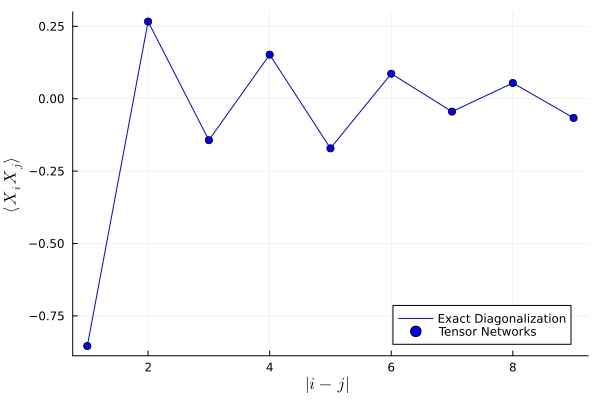

In [13]:
plot(Distance_ij_ED, real(Correlations_ED), label = "Exact Diagonalization", color = "blue")
scatter!(Distance_ij_TN, real(Correlations_TN), label = "Tensor Networks", color = "blue")
xlabel!(L"|i - j|")
ylabel!(L"\langle X_{i}X_{j} \rangle")

In [14]:
site_for_comparison = 5

t = 5
dt = 0.01

0.01

In [15]:
ψt_ED = zero
for i = 1:N-1
    i%2 == 0 ? ψt_ED = kron(ψt_ED, zero) : ψt_ED = kron(ψt_ED, one)
end
# ψt_ED == kron(zero, one, zero, one, zero, one, zero, one, zero, one)

Correlations_Dict_time_ED = Dict()
Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, ψt_ED)
Correlations_Dict_time_ED[0.0] = Correlations_ED
@show Correlations_ED[site_for_comparison]

U_ED = Time_Evolution_Op_Exact(dt, H_ED)

@time begin
for t = dt:dt:t
    ψt_ED = U_ED*ψt_ED
    Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, ψt_ED)
    Correlations_Dict_time_ED[t] = real(Correlations_ED)    
    @show Correlations_ED[site_for_comparison]
end
end

Correlations_ED[site_for_comparison] = 0.0
Correlations_ED[site_for_comparison] = -1.1606541360728747e-5 + 0.0im
Correlations_ED[site_for_comparison] = -4.639728138751623e-5 + 0.0im
Correlations_ED[site_for_comparison] = -0.00010428559035860012 + 0.0im
Correlations_ED[site_for_comparison] = -0.00018512716048644783 + 0.0im
Correlations_ED[site_for_comparison] = -0.00028872011947357205 + 0.0im
Correlations_ED[site_for_comparison] = -0.00041480519134598655 + 0.0im
Correlations_ED[site_for_comparison] = -0.0005630659063961039 + 0.0im
Correlations_ED[site_for_comparison] = -0.0007331288625569007 + 0.0im
Correlations_ED[site_for_comparison] = -0.0009245640409944615 + 0.0im
Correlations_ED[site_for_comparison] = -0.0011368851791415955 + 0.0im
Correlations_ED[site_for_comparison] = -0.0013695502047961 + 0.0im
Correlations_ED[site_for_comparison] = -0.0016219617352688828 + 0.0im
Correlations_ED[site_for_comparison] = -0.0018934676458852758 + 0.0im
Correlations_ED[site_for_comparison] = -0.00218

In [16]:
Ψt_MPS_TDVP = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_TDVP = Dict()
Correlations_TDVP, Distance_ij_TDVP = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TDVP)
Correlations_Dict_time_TDVP[0.0] = Correlations_TDVP
@show Correlations_TDVP[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_TDVP .= tdvp(H_MPO, -im * dt, Ψt_MPS_TDVP; time_step = -im * dt, cutoff = 10e-15, maxdim = 40, normalize = true)
    # normalize!(Ψt_MPS_TDVP)
    Correlations_TDVP, Distance_ij_TDVP = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TDVP)
    Correlations_Dict_time_TDVP[t] = real(Correlations_TDVP) 
    @show Correlations_TDVP[site_for_comparison]
end
end

Correlations_TDVP[site_for_comparison] = 0.0
Correlations_TDVP[site_for_comparison] = -4.42759891001704e-6 - 3.66222311623862e-16im
Correlations_TDVP[site_for_comparison] = -3.368689670823152e-5 - 1.3176169213026118e-17im
Correlations_TDVP[site_for_comparison] = -8.604925896900661e-5 - 3.2865122106761324e-18im
Correlations_TDVP[site_for_comparison] = -0.0001613862652353277 + 6.585682671353274e-18im
Correlations_TDVP[site_for_comparison] = -0.0002595028801380531 + 2.6450929429507698e-18im
Correlations_TDVP[site_for_comparison] = -0.0003801465755915733 + 1.1228629769085891e-18im
Correlations_TDVP[site_for_comparison] = -0.0005230076193785447 - 1.3961100102907326e-17im
Correlations_TDVP[site_for_comparison] = -0.0006877192936576551 - 6.740889384932699e-18im
Correlations_TDVP[site_for_comparison] = -0.0008738582176773044 - 2.82000516045701e-18im
Correlations_TDVP[site_for_comparison] = -0.0010809444821609504 - 2.5176476319733214e-17im
Correlations_TDVP[site_for_comparison] = -0.00130844266

$e^{tH} = 1 + tH + \cfrac{t^{2}}{2!} H^2 + \cfrac{t^{3}}{3!} H^3 + \cfrac{t^{4}}{4!} H^4$ 

In [17]:
dt_Taylor = -1im*dt
U_MPO = MPO(sites, "Id") + dt_Taylor*H_MPO + (dt_Taylor^2)*apply(H_MPO, H_MPO)/2 + (dt_Taylor^3)*apply(H_MPO, apply(H_MPO, H_MPO))/6 + (dt_Taylor^4)*apply(H_MPO,apply(H_MPO, apply(H_MPO, H_MPO)))/24 

Ψt_MPS_Taylor = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_Taylor = Dict()
Correlations_Taylor, Distance_ij_Taylor = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_Taylor)
Correlations_Dict_time_Taylor[0.0] = Correlations_Taylor
@show Correlations_Taylor[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_Taylor = apply(U_MPO, Ψt_MPS_Taylor; cutoff = 10e-15, maxdim = 40)
    normalize!(Ψt_MPS_Taylor)
    Correlations_Taylor, Distance_ij_Taylor = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_Taylor)
    Correlations_Dict_time_Taylor[t] = real(Correlations_Taylor)    
    @show Correlations_Taylor[site_for_comparison]
end
end

Correlations_Taylor[site_for_comparison] = 0.0
Correlations_Taylor[site_for_comparison] = -1.1605424543362682e-5 - 2.1265668144934058e-17im
Correlations_Taylor[site_for_comparison] = -4.639764954345947e-5 + 2.3872644697446934e-17im
Correlations_Taylor[site_for_comparison] = -0.00010428862004908779 - 7.966475764533446e-17im
Correlations_Taylor[site_for_comparison] = -0.00018513401739464298 + 1.3193932051086847e-16im
Correlations_Taylor[site_for_comparison] = -0.0002887334664240725 + 8.939245516871982e-17im
Correlations_Taylor[site_for_comparison] = -0.0004148203886872285 + 1.2256684072886303e-17im
Correlations_Taylor[site_for_comparison] = -0.0005630830968710806 + 1.703808099507675e-17im
Correlations_Taylor[site_for_comparison] = -0.0007331480623499225 - 2.9379291208965877e-16im
Correlations_Taylor[site_for_comparison] = -0.000924585125828267 + 9.30120504121818e-17im
Correlations_Taylor[site_for_comparison] = -0.0011369078544658752 - 9.53883984010443e-17im
Correlations_Taylor[site_for_c

Now for TEBD we need to do SWAPS, there are many different ways to do it:

In [18]:
# function ITensors.op(::OpName"SWAP", ::SiteType"Qubit", s1::Index, s2::Index)
#   mat = [1 0 0 0
#          0 0 1 0
#          0 1 0 0
#          0 0 0 1]
#   return itensor(mat, s2', s1', s2, s1)
# end
# os = [("SWAP", 1, 2)]
# SWAP = ops(os, sites)

# Ψt_MPS = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS
# @show Polarization = [inner(Ψt_MPS , apply(op("Z", s), Ψt_MPS)) for s = sites]; #It is important to check that I put the right numbers
# @show maxlinkdim(Ψt_MPS)

# @time Ψt_MPS = apply(SWAP, Ψt_MPS; maxdim = maxlinkdim(Ψt_MPS))
# @show Polarization = [inner(Ψt_MPS , apply(op("Z", s), Ψt_MPS)) for s = sites]; #It is important to check that I put the right numbers
# @show maxlinkdim(Ψt_MPS)

# #Another way (this is my favorite)
# SWAP = [1 0 0 0; 0 0 1 0; 0 1 0 0; 0 0 0 1] #Two-site SWAP gate

# s1, s2 = sites[1:2] 
# SWAP_op = op(SWAP, [s1,s2])
# @time Ψt_MPS = apply(SWAP_op , Ψt_MPS; maxdim = maxlinkdim(Ψt_MPS))
# @show Polarization = [inner(Ψt_MPS , apply(op("Z", s), Ψt_MPS)) for s = sites]; #It is important to check that I put the right numbers
# @show maxlinkdim(Ψt_MPS)

In [19]:
function TEBD_Build_Gates(dt, sites, J, α)

    N = length(sites)

    SWAP = [1 0 0 0; 0 0 1 0; 0 1 0 0; 0 0 0 1] #Two-site SWAP gate
    
    TEBD_Gates = ITensor[] 
    
    for j = 1:N-1
        distance_ij = 1
        for i = 1:N-1
            # i <= N-j ? println(distance_ij) : nothing
            
            s1, s2 = sites[i:i+1] 
            H_gate = J*exp(-α*distance_ij)*(op("X",s1)*op("X",s2) + op("Y",s1)*op("Y",s2))
            U_Gate = exp(-0.5im*dt*H_gate)
            if i <= N-j 
                push!(TEBD_Gates, U_Gate) 
                distance_ij = distance_ij + 1 
            end
            SWAP_op = op(SWAP, [s1,s2])
            push!(TEBD_Gates, SWAP_op)
        end
    end

    append!(TEBD_Gates, reverse(TEBD_Gates))

    return TEBD_Gates
end

TEBD_Build_Gates (generic function with 1 method)

In [20]:
TEBD_Gates = TEBD_Build_Gates(dt, sites, J, α);

In [21]:
Ψt_MPS_TEBD = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_TEBD = Dict()
Correlations_TEBD, Distance_ij_TEBD = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TEBD)
Correlations_Dict_time_TEBD[0.0] = Correlations_TEBD
@show Correlations_TEBD[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_TEBD = apply(TEBD_Gates, Ψt_MPS_TEBD; cutoff = 10e-15, maxdim = 40)
    normalize!(Ψt_MPS_TEBD)
    Correlations_TEBD, Distance_ij_TEBD = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TEBD)
    Correlations_Dict_time_TEBD[t] = real(Correlations_TEBD)  
    @show Correlations_TEBD[site_for_comparison]
end
end

Correlations_TEBD[site_for_comparison] = 0.0
Correlations_TEBD[site_for_comparison] = -1.1597348331964836e-5 - 5.56568532556096e-18im
Correlations_TEBD[site_for_comparison] = -4.6390803033862884e-5 + 2.1806960047887523e-17im
Correlations_TEBD[site_for_comparison] = -0.00010429336039546342 + 1.3155407902477808e-18im
Correlations_TEBD[site_for_comparison] = -0.0001851496372708357 - 1.4959912352632183e-17im
Correlations_TEBD[site_for_comparison] = -0.00028874376887294946 + 6.255969322675691e-18im
Correlations_TEBD[site_for_comparison] = -0.0004148340056602302 + 2.28454966361596e-17im
Correlations_TEBD[site_for_comparison] = -0.0005630863425300362 - 2.155322625534089e-19im
Correlations_TEBD[site_for_comparison] = -0.00073317278579759 - 2.907545428772387e-17im
Correlations_TEBD[site_for_comparison] = -0.0009246023950760469 - 4.429213199989156e-18im
Correlations_TEBD[site_for_comparison] = -0.0011369305032081314 - 1.2637264881932882e-19im
Correlations_TEBD[site_for_comparison] = -0.001369601

For W1 we create the corresponding evolution operator as follows:

In [22]:
function get_U_W1(sites, J, α, dt)
    # Create object for MPO with bond dimensions
    N = length(sites);
    U_W1 = MPO(N);
    bondindex = [Index(3, "Link,l="*string(n)) for n in 1:N-1];

    # Left core
    n = 1;
    core = ITensor(ComplexF64, sites[n], sites[n]', bondindex[n]);
    # core[1] = I
    core[sites[n]=>1, sites[n]'=>1, bondindex[n]=>1] = 1.0;
    core[sites[n]=>2, sites[n]'=>2, bondindex[n]=>1] = 1.0;
    # core[2] = √dt exp(-α) X
    core[sites[n]=>1, sites[n]'=>2, bondindex[n]=>2] = √(dt)*exp(-α);
    core[sites[n]=>2, sites[n]'=>1, bondindex[n]=>2] = √(dt)*exp(-α);
    # core[3] = √dt exp(-α) Y
    core[sites[n]=>1, sites[n]'=>2, bondindex[n]=>3] = -1im*√(dt)*exp(-α);
    core[sites[n]=>2, sites[n]'=>1, bondindex[n]=>3] = 1im*√(dt)*exp(-α);
    U_W1[n] = core;

    # Center cores
    for n in 2:N-1
        core = ITensor(ComplexF64, bondindex[n-1], sites[n], sites[n]', bondindex[n]);
        # core[1,1] = I
        core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>1, bondindex[n]=>1] = 1.0;
        core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>2, bondindex[n]=>1] = 1.0;
        # core[1,2] = √dt exp(-α) X
        core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>2, bondindex[n]=>2] = √(dt)*exp(-α);
        core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>1, bondindex[n]=>2] = √(dt)*exp(-α);
        # core[1,3] = √dt exp(-α) Y
        core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>2, bondindex[n]=>3] = -1im*√(dt)*exp(-α);
        core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>1, bondindex[n]=>3] = 1im*√(dt)*exp(-α);
        # core[2,1] = √dt J X
        core[bondindex[n-1]=>2, sites[n]=>1, sites[n]'=>2, bondindex[n]=>1] = √(dt)*J;
        core[bondindex[n-1]=>2, sites[n]=>2, sites[n]'=>1, bondindex[n]=>1] = √(dt)*J;
        # core[3,1] = √dt J Y
        core[bondindex[n-1]=>3, sites[n]=>1, sites[n]'=>2, bondindex[n]=>1] = -1im*√(dt)*J;
        core[bondindex[n-1]=>3, sites[n]=>2, sites[n]'=>1, bondindex[n]=>1] = 1im*√(dt)*J;
        # core[2,2] = exp(-α) I
        core[bondindex[n-1]=>2, sites[n]=>1, sites[n]'=>1, bondindex[n]=>2] = exp(-α);
        core[bondindex[n-1]=>2, sites[n]=>2, sites[n]'=>2, bondindex[n]=>2] = exp(-α);
        # core[3,3] = exp(-α) I
        core[bondindex[n-1]=>3, sites[n]=>1, sites[n]'=>1, bondindex[n]=>3] = exp(-α);
        core[bondindex[n-1]=>3, sites[n]=>2, sites[n]'=>2, bondindex[n]=>3] = exp(-α);
        U_W1[n] = core;
    end;

    # Right core
    n = N;
    core = ITensor(ComplexF64, bondindex[n-1], sites[n], sites[n]');
    # core[1,1] = I
    core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>1] = 1.0;
    core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>2] = 1.0;
    # core[2,1] = √dt J X
    core[bondindex[n-1]=>2, sites[n]=>1, sites[n]'=>2] = √(dt)*J;
    core[bondindex[n-1]=>2, sites[n]=>2, sites[n]'=>1] = √(dt)*J;
    # core[3,1] = √dt J Y
    core[bondindex[n-1]=>3, sites[n]=>1, sites[n]'=>2] = -1im*√(dt)*J;
    core[bondindex[n-1]=>3, sites[n]=>2, sites[n]'=>1] = 1im*√(dt)*J;
    U_W1[n] = core;

    return U_W1;
end;

In [23]:
dt_W1 = -1im*dt;
U_MPO = get_U_W1(sites, J, α, dt_W1);

Ψt_MPS_W1 = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_W1 = Dict()
Correlations_W1, Distance_ij_W1 = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_W1)
Correlations_Dict_time_W1[0.0] = Correlations_W1
@show Correlations_W1[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_W1 = apply(U_MPO, Ψt_MPS_W1; cutoff = 10e-15, maxdim = 40)
    normalize!(Ψt_MPS_W1)
    Correlations_W1, Distance_ij_W1 = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_W1)
    Correlations_Dict_time_W1[t] = real(Correlations_W1)    
    @show Correlations_W1[site_for_comparison]
end
end

Correlations_W1[site_for_comparison] = 0.0
Correlations_W1[site_for_comparison] = 6.364469789250194e-17 + 9.302233815997961e-17im
Correlations_W1[site_for_comparison] = -2.3201445450736485e-5 - 7.3848347980388e-18im
Correlations_W1[site_for_comparison] = -6.955644719514164e-5 + 8.394318221632752e-18im
Correlations_W1[site_for_comparison] = -0.00013895866172918204 + 3.984303183695822e-18im
Correlations_W1[site_for_comparison] = -0.00023124490647473883 + 1.3497042910071014e-17im
Correlations_W1[site_for_comparison] = -0.00034619403796954144 + 4.157705719110171e-19im
Correlations_W1[site_for_comparison] = -0.0004835195849102556 + 4.129985365817642e-18im
Correlations_W1[site_for_comparison] = -0.0006428881367989137 + 7.121717211739326e-18im
Correlations_W1[site_for_comparison] = -0.0008239043349444607 - 3.626611890471269e-18im
Correlations_W1[site_for_comparison] = -0.0010261155029092344 + 4.839596096064445e-18im
Correlations_W1[site_for_comparison] = -0.001249011897021458 - 3.553176556580

Let's compare all methods

In [24]:
function get_cor_dist_t_fromDict(Dict, dist, times)

    array = []
    for t = times
        append!(array, Dict[t][dist])
    end

    return array
end    

get_cor_dist_t_fromDict (generic function with 1 method)

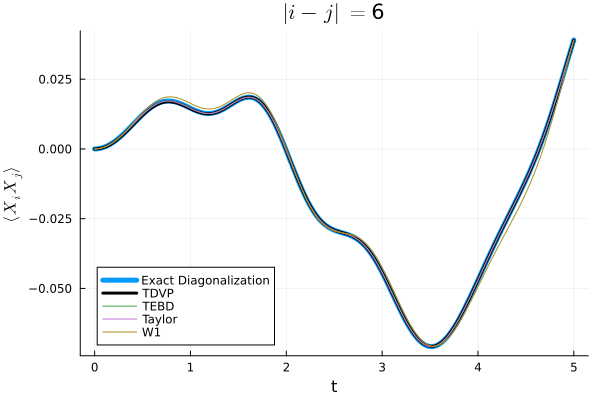

In [25]:
dist_for_comparison =  6
times =  0.0:dt:t

plot(times, get_cor_dist_t_fromDict(Correlations_Dict_time_ED, dist_for_comparison, times), label = "Exact Diagonalization", linewidth = 5.0)
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_TDVP, dist_for_comparison, times), label = "TDVP", linewidth = 3.0, color = "black")
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_TEBD, dist_for_comparison, times), label = "TEBD", linewidth = 1.0)
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_Taylor, dist_for_comparison, times), label = "Taylor", linewidth = 1.0)
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_W1, dist_for_comparison, times), label = "W1", linewidth = 1.0)

xlabel!("t")
ylabel!(L"\langle X_{i} X_{j} \rangle")
title!(L"| i - j | = "*"$dist_for_comparison")

**Pendiente:**

- Implementar W1 (importante jaja) 
- Comparar tiempos y ver cual está más cerca del caso exacto
- Comparar para cadenas más largas y correlaciones más lejanas
- GPU?

# Comparar

In [26]:
function evolve_ED(N, J, α, t, dt)
    # Operators
    H_ED = Build_H_Exact(N, J, α);
    U_ED = Time_Evolution_Op_Exact(dt, H_ED);
    
    # Initial conditions
    ψt_ED = zero;
    for i = 1:N-1
        i%2 == 0 ? ψt_ED = kron(ψt_ED, zero) : ψt_ED = kron(ψt_ED, one);
    end;

    # Save data
    Correlations_Dict_time_ED = Dict();
    Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, ψt_ED);
    Correlations_Dict_time_ED[0.0] = Correlations_ED;

    # ED
    exec_time = @elapsed begin
        for t = dt:dt:t
            ψt_ED = U_ED*ψt_ED;
            Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, ψt_ED);
            Correlations_Dict_time_ED[t] = real(Correlations_ED);
            println("t=", t);
        end;
    end;

    return Correlations_Dict_time_ED, exec_time;
end;

In [27]:
function evolve_TDVP(N, J, α, t, dt, χmax, tol)
    # Operators
    sites = siteinds("Qubit", N);
    H_MPO = Build_H_MPO(sites, J, α);
    
    # Initial conditions
    Ψt_MPS_TDVP   = MPS(sites, [(i%2) + 1 for i=0:N-1]); #Initial MPS

    # Save data
    Correlations_Dict_time_TDVP = Dict();
    Correlations_TDVP, Distance_ij_TDVP = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TDVP);
    Correlations_Dict_time_TDVP[0.0] = Correlations_TDVP;

    # TDVP
    exec_time = @elapsed begin
        for t = dt:dt:t
            Ψt_MPS_TDVP .= tdvp(H_MPO, -im * dt, Ψt_MPS_TDVP; time_step = -im * dt, cutoff = tol, maxdim = χmax, normalize = true);
            Correlations_TDVP, Distance_ij_TDVP = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TDVP);
            Correlations_Dict_time_TDVP[t] = real(Correlations_TDVP);
            println("t=", t);
        end;
    end;

    return Correlations_Dict_time_TDVP, exec_time;
end;

In [28]:
function evolve_Taylor(N, J, α, t, dt, χmax, tol)
    # Operators
    sites = siteinds("Qubit", N);
    H_MPO = Build_H_MPO(sites, J, α);
    dt_Taylor = -1im*dt;
    U_MPO = MPO(sites, "Id") + dt_Taylor*H_MPO + (dt_Taylor^2)*apply(H_MPO, H_MPO)/2 + (dt_Taylor^3)*apply(H_MPO, apply(H_MPO, H_MPO))/6 + (dt_Taylor^4)*apply(H_MPO,apply(H_MPO, apply(H_MPO, H_MPO)))/24 #1 + tH + t^2 H^2 + t^3 H^3
    
    # Initial conditions
    Ψt_MPS_Taylor = MPS(sites, [(i%2) + 1 for i=0:N-1]); #Initial MPS

    # Save data
    Correlations_Dict_time_Taylor = Dict();
    Correlations_Taylor, Distance_ij_Taylor = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_Taylor);
    Correlations_Dict_time_Taylor[0.0] = Correlations_Taylor;

    # Taylor
    exec_time = @elapsed  begin
        for t = dt:dt:t
            Ψt_MPS_Taylor = apply(U_MPO, Ψt_MPS_Taylor; cutoff = 10e-15, maxdim = 40);
            normalize!(Ψt_MPS_Taylor);
            Correlations_Taylor, Distance_ij_Taylor = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_Taylor);
            Correlations_Dict_time_Taylor[t] = real(Correlations_Taylor);
            println("t=", t);
        end;
    end;

    return Correlations_Dict_time_Taylor, exec_time;
end;

In [29]:
function evolve_TEBD(N, J, α, t, dt, χmax, tol)
    # Operators
    sites = siteinds("Qubit", N);
    TEBD_Gates = TEBD_Build_Gates(dt, sites, J, α);
    
    # Initial conditions
    Ψt_MPS_TEBD   = MPS(sites, [(i%2) + 1 for i=0:N-1]); #Initial MPS

    # Save data
    Correlations_Dict_time_TEBD = Dict();
    Correlations_TEBD, Distance_ij_TEBD = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TEBD);
    Correlations_Dict_time_TEBD[0.0] = Correlations_TEBD;

    # TEBD
    exec_time = @elapsed  begin
        for t = dt:dt:t
            Ψt_MPS_TEBD = apply(TEBD_Gates, Ψt_MPS_TEBD; cutoff = 10e-15, maxdim = 40);
            normalize!(Ψt_MPS_TEBD);
            Correlations_TEBD, Distance_ij_TEBD = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TEBD);
            Correlations_Dict_time_TEBD[t] = real(Correlations_TEBD);
            println("t=", t);
        end;
    end;

    return Correlations_Dict_time_TEBD, exec_time;
end;

In [30]:
function evolve_W1(N, J, α, t, dt, χmax, tol)
    # Operators
    sites = siteinds("Qubit", N);
    U_MPO = get_U_W1(sites, J, α, -1im*dt);
    
    # Initial conditions
    Ψt_MPS_W1 = MPS(sites, [(i%2) + 1 for i=0:N-1]); #Initial MPS

    # Save data
    Correlations_Dict_time_W1 = Dict();
    Correlations_W1, Distance_ij_W1 = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_W1);
    Correlations_Dict_time_W1[0.0] = Correlations_W1;

    # W1
    exec_time = @elapsed  begin
        for t = dt:dt:t
            Ψt_MPS_W1 = apply(U_MPO, Ψt_MPS_W1; cutoff = 10e-15, maxdim = 40);
            normalize!(Ψt_MPS_W1);
            Correlations_W1, Distance_ij_W1 = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_W1);
            Correlations_Dict_time_W1[t] = real(Correlations_W1);
            println("t=", t);
        end;
    end;

    return Correlations_Dict_time_W1, exec_time;
end;

In [31]:
N = 10;
α = 1.0;
J = -exp(α);

t = 1.0;
dt = 0.01;

χmax = 40;
tol = 1e-10;

times =  0.0:dt:t;
println("ED:")
Corr_ED, T_ED = evolve_ED(N, J, α, t, dt);
println("TDVP:")
Corr_TDVP, T_TDVP = evolve_TDVP(N, J, α, t, dt, χmax, tol);
println("Taylor:")
Corr_Taylor, T_Taylor = evolve_Taylor(N, J, α, t, dt, χmax, tol);
println("TEBD:")
Corr_TEBD, T_TEBD = evolve_TEBD(N, J, α, t, dt, χmax, tol);
println("W1:")
Corr_W1, T_W1 = evolve_W1(N, J, α, t, dt, χmax, tol);

ED:
t=0.01
t=0.02
t=0.03
t=0.04
t=0.05
t=0.06
t=0.07
t=0.08
t=0.09
t=0.1
t=0.11
t=0.12
t=0.13
t=0.14
t=0.15
t=0.16
t=0.17
t=0.18
t=0.19
t=0.2
t=0.21
t=0.22
t=0.23
t=0.24
t=0.25
t=0.26
t=0.27
t=0.28
t=0.29
t=0.3
t=0.31
t=0.32
t=0.33
t=0.34
t=0.35
t=0.36
t=0.37
t=0.38
t=0.39
t=0.4
t=0.41
t=0.42
t=0.43
t=0.44
t=0.45
t=0.46
t=0.47
t=0.48
t=0.49
t=0.5
t=0.51
t=0.52
t=0.53
t=0.54
t=0.55
t=0.56
t=0.57
t=0.58
t=0.59
t=0.6
t=0.61
t=0.62
t=0.63
t=0.64
t=0.65
t=0.66
t=0.67
t=0.68
t=0.69
t=0.7
t=0.71
t=0.72
t=0.73
t=0.74
t=0.75
t=0.76
t=0.77
t=0.78
t=0.79
t=0.8
t=0.81
t=0.82
t=0.83
t=0.84
t=0.85
t=0.86
t=0.87
t=0.88
t=0.89
t=0.9
t=0.91
t=0.92
t=0.93
t=0.94
t=0.95
t=0.96
t=0.97
t=0.98
t=0.99
t=1.0
TDVP:
t=0.01
t=0.02
t=0.03
t=0.04
t=0.05
t=0.06
t=0.07
t=0.08
t=0.09
t=0.1
t=0.11
t=0.12
t=0.13
t=0.14
t=0.15
t=0.16
t=0.17
t=0.18
t=0.19
t=0.2
t=0.21
t=0.22
t=0.23
t=0.24
t=0.25
t=0.26
t=0.27
t=0.28
t=0.29
t=0.3
t=0.31
t=0.32
t=0.33
t=0.34
t=0.35
t=0.36
t=0.37
t=0.38
t=0.39
t=0.4
t=0.41
t=0.42
t=0.43
t=0

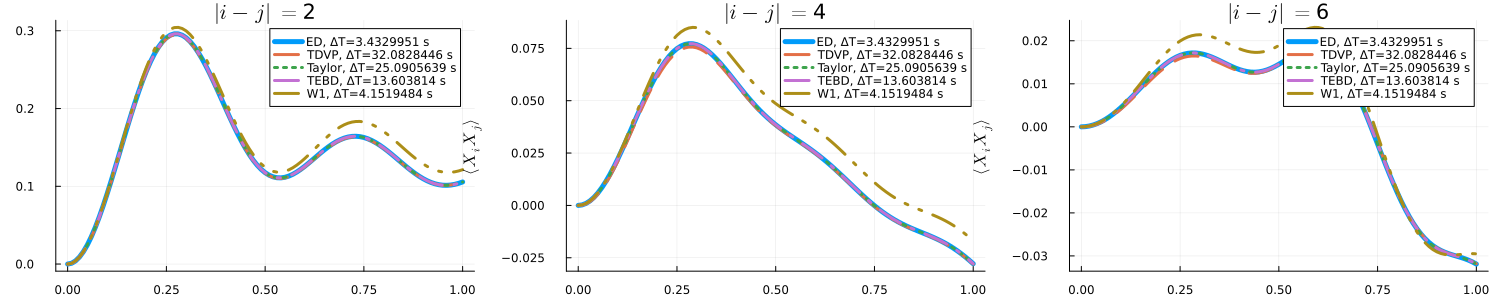

In [32]:
dx =  2;
plot(times, get_cor_dist_t_fromDict(Corr_ED, dx, times), label = "ED, ΔT="*string(T_ED)*" s", linewidth = 5.0, linestyle=:solid)
plot!(times, get_cor_dist_t_fromDict(Corr_TDVP, dx, times), label = "TDVP, ΔT="*string(T_TDVP)*" s", linewidth = 3.0, linestyle=:dash)
plot!(times, get_cor_dist_t_fromDict(Corr_Taylor, dx, times), label = "Taylor, ΔT="*string(T_Taylor)*" s", linewidth = 3.0, linestyle=:dot)
plot!(times, get_cor_dist_t_fromDict(Corr_TEBD, dx, times), label = "TEBD, ΔT="*string(T_TEBD)*" s", linewidth = 3.0, linestyle=:dashdot)
p1 = plot!(times, get_cor_dist_t_fromDict(Corr_W1, dx, times), label = "W1, ΔT="*string(T_W1)*" s", linewidth = 3.0, linestyle=:dashdotdot)
title!(L"| i - j | = "*"$dx")

dx =  4;
plot(times, get_cor_dist_t_fromDict(Corr_ED, dx, times), label = "ED, ΔT="*string(T_ED)*" s", linewidth = 5.0, linestyle=:solid)
plot!(times, get_cor_dist_t_fromDict(Corr_TDVP, dx, times), label = "TDVP, ΔT="*string(T_TDVP)*" s", linewidth = 3.0, linestyle=:dash)
plot!(times, get_cor_dist_t_fromDict(Corr_Taylor, dx, times), label = "Taylor, ΔT="*string(T_Taylor)*" s", linewidth = 3.0, linestyle=:dot)
plot!(times, get_cor_dist_t_fromDict(Corr_TEBD, dx, times), label = "TEBD, ΔT="*string(T_TEBD)*" s", linewidth = 3.0, linestyle=:dashdot)
p2 = plot!(times, get_cor_dist_t_fromDict(Corr_W1, dx, times), label = "W1, ΔT="*string(T_W1)*" s", linewidth = 3.0, linestyle=:dashdotdot)
title!(L"| i - j | = "*"$dx")

dx =  6;
plot(times, get_cor_dist_t_fromDict(Corr_ED, dx, times), label = "ED, ΔT="*string(T_ED)*" s", linewidth = 5.0, linestyle=:solid)
plot!(times, get_cor_dist_t_fromDict(Corr_TDVP, dx, times), label = "TDVP, ΔT="*string(T_TDVP)*" s", linewidth = 3.0, linestyle=:dash)
plot!(times, get_cor_dist_t_fromDict(Corr_Taylor, dx, times), label = "Taylor, ΔT="*string(T_Taylor)*" s", linewidth = 3.0, linestyle=:dot)
plot!(times, get_cor_dist_t_fromDict(Corr_TEBD, dx, times), label = "TEBD, ΔT="*string(T_TEBD)*" s", linewidth = 3.0, linestyle=:dashdot)
p3 = plot!(times, get_cor_dist_t_fromDict(Corr_W1, dx, times), label = "W1, ΔT="*string(T_W1)*" s", linewidth = 3.0, linestyle=:dashdotdot)
title!(L"| i - j | = "*"$dx")

plot(p1, p2, p3, layout=(1,3), legend=true, size = (1500,300))
xlabel!("t")
ylabel!(L"\langle X_{i} X_{j} \rangle")

In [33]:
N = 10;
α = 10.0;
J = -exp(α);

t = 1.0;
dt = 0.01;

χmax = 40;
tol = 1e-10;

times_1 =  0.0:dt:t;
println("ED:")
Corr_ED_1, T_ED_1 = evolve_ED(N, J, α, t, dt);
println("TDVP:")
Corr_TDVP_1, T_TDVP_1 = evolve_TDVP(N, J, α, t, dt, χmax, tol);
println("Taylor:")
Corr_Taylor_1, T_Taylor_1 = evolve_Taylor(N, J, α, t, dt, χmax, tol);
println("TEBD:")
Corr_TEBD_1, T_TEBD_1 = evolve_TEBD(N, J, α, t, dt, χmax, tol);
println("W1:")
Corr_W1_1, T_W1_1 = evolve_W1(N, J, α, t, dt, χmax, tol);

α = 1.0;
J = -exp(α);

times_2 =  0.0:dt:t;
println("ED:")
Corr_ED_2, T_ED_2 = evolve_ED(N, J, α, t, dt);
println("TDVP:")
Corr_TDVP_2, T_TDVP_2 = evolve_TDVP(N, J, α, t, dt, χmax, tol);
println("Taylor:")
Corr_Taylor_2, T_Taylor_2 = evolve_Taylor(N, J, α, t, dt, χmax, tol);
println("TEBD:")
Corr_TEBD_2, T_TEBD_2 = evolve_TEBD(N, J, α, t, dt, χmax, tol);
println("W1:")
Corr_W1_2, T_W1_2 = evolve_W1(N, J, α, t, dt, χmax, tol);

α = 0.1;
J = -exp(α);

times_3 =  0.0:dt:t;
println("ED:")
Corr_ED_3, T_ED_3 = evolve_ED(N, J, α, t, dt);
println("TDVP:")
Corr_TDVP_3, T_TDVP_3 = evolve_TDVP(N, J, α, t, dt, χmax, tol);
println("Taylor:")
Corr_Taylor_3, T_Taylor_3 = evolve_Taylor(N, J, α, t, dt, χmax, tol);
println("TEBD:")
Corr_TEBD_3, T_TEBD_3 = evolve_TEBD(N, J, α, t, dt, χmax, tol);
println("W1:")
Corr_W1_3, T_W1_3 = evolve_W1(N, J, α, t, dt, χmax, tol);

ED:
t=0.01
t=0.02
t=0.03
t=0.04
t=0.05
t=0.06
t=0.07
t=0.08
t=0.09
t=0.1
t=0.11
t=0.12
t=0.13
t=0.14
t=0.15
t=0.16
t=0.17
t=0.18
t=0.19
t=0.2
t=0.21
t=0.22
t=0.23
t=0.24
t=0.25
t=0.26
t=0.27
t=0.28
t=0.29
t=0.3
t=0.31
t=0.32
t=0.33
t=0.34
t=0.35
t=0.36
t=0.37
t=0.38
t=0.39
t=0.4
t=0.41
t=0.42
t=0.43
t=0.44
t=0.45
t=0.46
t=0.47
t=0.48
t=0.49
t=0.5
t=0.51
t=0.52
t=0.53
t=0.54
t=0.55
t=0.56
t=0.57
t=0.58
t=0.59
t=0.6
t=0.61
t=0.62
t=0.63
t=0.64
t=0.65
t=0.66
t=0.67
t=0.68
t=0.69
t=0.7
t=0.71
t=0.72
t=0.73
t=0.74
t=0.75
t=0.76
t=0.77
t=0.78
t=0.79
t=0.8
t=0.81
t=0.82
t=0.83
t=0.84
t=0.85
t=0.86
t=0.87
t=0.88
t=0.89
t=0.9
t=0.91
t=0.92
t=0.93
t=0.94
t=0.95
t=0.96
t=0.97
t=0.98
t=0.99
t=1.0
TDVP:
t=0.01
t=0.02
t=0.03
t=0.04
t=0.05
t=0.06
t=0.07
t=0.08
t=0.09
t=0.1
t=0.11
t=0.12
t=0.13
t=0.14
t=0.15
t=0.16
t=0.17
t=0.18
t=0.19
t=0.2
t=0.21
t=0.22
t=0.23
t=0.24
t=0.25
t=0.26
t=0.27
t=0.28
t=0.29
t=0.3
t=0.31
t=0.32
t=0.33
t=0.34
t=0.35
t=0.36
t=0.37
t=0.38
t=0.39
t=0.4
t=0.41
t=0.42
t=0.43
t=0

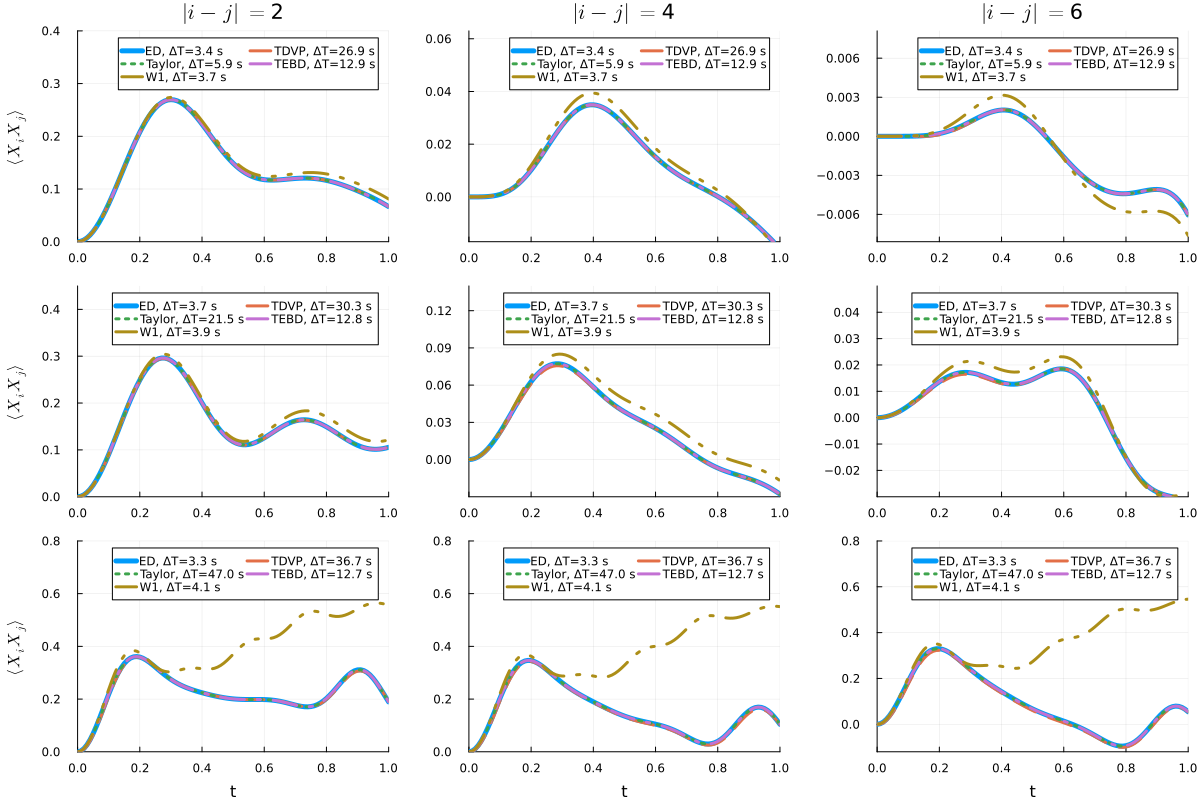

In [ ]:
p = []

for dx in [2, 4, 6]
    if dx == 2
        yrange = (0,0.4);
        ylab = L"\langle X_{i} X_{j} \rangle";
    elseif dx == 4
        yrange = (-0.017,0.063);
        ylab = "";
    elseif dx == 6
        yrange = (-0.0081,0.0081);
        ylab = "";
    end;
    plot(times_1, get_cor_dist_t_fromDict(Corr_ED_1, dx, times_1), label = "ED, ΔT="*string(round(T_ED_1, digits = 1))*" s", xlims=(0,1), ylims=yrange, linewidth = 5.0, linestyle=:solid, ylabel=ylab)
    plot!(times_1, get_cor_dist_t_fromDict(Corr_TDVP_1, dx, times_1), label = "TDVP, ΔT="*string(round(T_TDVP_1, digits = 1))*" s", linewidth = 3.0, linestyle=:dash)
    plot!(times_1, get_cor_dist_t_fromDict(Corr_Taylor_1, dx, times_1), label = "Taylor, ΔT="*string(round(T_Taylor_1, digits = 1))*" s", linewidth = 3.0, linestyle=:dot)
    plot!(times_1, get_cor_dist_t_fromDict(Corr_TEBD_1, dx, times_1), label = "TEBD, ΔT="*string(round(T_TEBD_1, digits = 1))*" s", linewidth = 3.0, linestyle=:dashdot)
    px = plot!(times_1, get_cor_dist_t_fromDict(Corr_W1_1, dx, times_1), label = "W1, ΔT="*string(round(T_W1_1, digits = 1))*" s", linewidth = 3.0, linestyle=:dashdotdot)
    title!(L"| i - j | = "*"$dx")
    push!(p, px);
end;

for dx in [2, 4, 6]
    if dx == 2
        yrange = (0,0.45);
        ylab = L"\langle X_{i} X_{j} \rangle";
    elseif dx == 4
        yrange = (-0.03,0.14);
        ylab = "";
    elseif dx == 6
        yrange = (-0.03,0.05);
        ylab = "";
    end;
    plot(times_2, get_cor_dist_t_fromDict(Corr_ED_2, dx, times_2), label = "ED, ΔT="*string(round(T_ED_2, digits = 1))*" s", xlims=(0,1), ylims=yrange, linewidth = 5.0, linestyle=:solid, ylabel=ylab)
    plot!(times_2, get_cor_dist_t_fromDict(Corr_TDVP_2, dx, times_2), label = "TDVP, ΔT="*string(round(T_TDVP_2, digits = 1))*" s", linewidth = 3.0, linestyle=:dash)
    plot!(times_2, get_cor_dist_t_fromDict(Corr_Taylor_2, dx, times_2), label = "Taylor, ΔT="*string(round(T_Taylor_2, digits = 1))*" s", linewidth = 3.0, linestyle=:dot)
    plot!(times_2, get_cor_dist_t_fromDict(Corr_TEBD_2, dx, times_2), label = "TEBD, ΔT="*string(round(T_TEBD_2, digits = 1))*" s", linewidth = 3.0, linestyle=:dashdot)
    px = plot!(times_2, get_cor_dist_t_fromDict(Corr_W1_2, dx, times_2), label = "W1, ΔT="*string(round(T_W1_2, digits = 1))*" s", linewidth = 3.0, linestyle=:dashdotdot)
    push!(p, px);
end;

for dx in [2, 4, 6]
    if dx == 2
        yrange = (0,0.8);
        ylab = L"\langle X_{i} X_{j} \rangle";
    elseif dx == 4
        yrange = (0,0.8);
        ylab = "";
    elseif dx == 6
        yrange = (-0.12,0.8);
        ylab = "";
    end;
    plot(times_3, get_cor_dist_t_fromDict(Corr_ED_3, dx, times_3), label = "ED, ΔT="*string(round(T_ED_3, digits = 1))*" s", xlims=(0,1), ylims=yrange, linewidth = 5.0, linestyle=:solid, xlabel="t", ylabel=ylab)
    plot!(times_3, get_cor_dist_t_fromDict(Corr_TDVP_3, dx, times_3), label = "TDVP, ΔT="*string(round(T_TDVP_3, digits = 1))*" s", linewidth = 3.0, linestyle=:dash)
    plot!(times_3, get_cor_dist_t_fromDict(Corr_Taylor_3, dx, times_3), label = "Taylor, ΔT="*string(round(T_Taylor_3, digits = 1))*" s", linewidth = 3.0, linestyle=:dot)
    plot!(times_3, get_cor_dist_t_fromDict(Corr_TEBD_3, dx, times_3), label = "TEBD, ΔT="*string(round(T_TEBD_3, digits = 1))*" s", linewidth = 3.0, linestyle=:dashdot)
    px = plot!(times_3, get_cor_dist_t_fromDict(Corr_W1_3, dx, times_3), label = "W1, ΔT="*string(round(T_W1_3, digits = 1))*" s", linewidth = 3.0, linestyle=:dashdotdot)
    push!(p, px);
end;


plot(p..., layout=(3,3), legend=:topright, legend_column=2, size = (1200,800), left_margin = 5Plots.mm)
png("Comparison.png")

In [ ]:
p = []

# Correlations

plot(Corr_ED_1[times_1[end]], label = "ED", marker=:o, linewidth = 3.0, linestyle=:solid, color = :blue);
plot!(Corr_TDVP_1[times_1[end]], label = "TDVP", marker=:s, linewidth = 2.0, linestyle=:dash, color = :red);
plot!(Corr_Taylor_1[times_1[end]], label = "Taylor", marker=:x, linewidth = 2.0, linestyle=:dot, color = :green);
plot!(Corr_TEBD_1[times_1[end]], label = "TEBD", marker=:d, linewidth = 2.0, linestyle=:dashdot, color = :purple);
px = plot!(Corr_W1_1[times_1[end]], label = "W1", marker=:hex, linewidth = 2.0, linestyle=:dashdotdot, color = :orange, 
        xlims=(1,9), ylims=(-0.025,0.09), ylabel=L"\langle X_{i} X_{j} \rangle", title=L"\alpha=10.0");
push!(p, px);

plot(Corr_ED_2[times_2[end]], label = "ED", marker=:o, linewidth = 3.0, linestyle=:solid, color = :blue);
plot!(Corr_TDVP_2[times_2[end]], label = "TDVP", marker=:s, linewidth = 2.0, linestyle=:dash, color = :red);
plot!(Corr_Taylor_2[times_2[end]], label = "Taylor", marker=:x, linewidth = 2.0, linestyle=:dot, color = :green);
plot!(Corr_TEBD_2[times_2[end]], label = "TEBD", marker=:d, linewidth = 2.0, linestyle=:dashdot, color = :purple);
px = plot!(Corr_W1_2[times_2[end]], label = "W1", marker=:hex, linewidth = 2.0, linestyle=:dashdotdot, color = :orange, xlims=(1,9), title=L"\alpha=1.0");
push!(p, px);

plot(Corr_ED_3[times_3[end]], label = "ED", marker=:o, linewidth = 3.0, linestyle=:solid, color = :blue);
plot!(Corr_TDVP_3[times_3[end]], label = "TDVP", marker=:s, linewidth = 2.0, linestyle=:dash, color = :red);
plot!(Corr_Taylor_3[times_3[end]], label = "Taylor", marker=:x, linewidth = 2.0, linestyle=:dot, color = :green);
plot!(Corr_TEBD_3[times_3[end]], label = "TEBD", marker=:d, linewidth = 2.0, linestyle=:dashdot, color = :purple);
px = plot!(Corr_W1_3[times_3[end]], label = "W1", marker=:hex, linewidth = 2.0, linestyle=:dashdotdot, color = :orange, xlims=(1,9), title=L"\alpha=0.1");
push!(p, px);

# Error

plot(abs.(Corr_TDVP_1[times_1[end]]-Corr_ED_1[times_1[end]]), label = "TDVP", marker=:s, linewidth = 2.0, linestyle=:dash, color = :red);
plot!(abs.(Corr_Taylor_1[times_1[end]]-Corr_ED_1[times_1[end]]), label = "Taylor", marker=:x, linewidth = 2.0, linestyle=:dot, color = :green);
plot!(abs.(Corr_TEBD_1[times_1[end]]-Corr_ED_1[times_1[end]]), label = "TEBD", marker=:d, linewidth = 2.0, linestyle=:dashdot, color = :purple);
px = plot!(abs.(Corr_W1_1[times_1[end]]-Corr_ED_1[times_1[end]]), label = "W1", marker=:hex, linewidth = 2.0, linestyle=:dashdotdot, yaxis=:log, color = :orange, 
            xlims=(1,9), ylims=(1e-9,1e-0), xlabel=L"| i - j |", ylabel=L"|\langle X_{i} X_{j}\rangle - \langle X_{i} X_{j}\rangle_{\rm{ED}}|");
push!(p, px);

plot(abs.(Corr_TDVP_2[times_2[end]]-Corr_ED_2[times_2[end]]), label = "TDVP", marker=:s, linewidth = 2.0, linestyle=:dash, color = :red);
plot!(abs.(Corr_Taylor_2[times_2[end]]-Corr_ED_2[times_2[end]]), label = "Taylor", marker=:x, linewidth = 2.0, linestyle=:dot, color = :green);
plot!(abs.(Corr_TEBD_2[times_2[end]]-Corr_ED_2[times_2[end]]), label = "TEBD", marker=:d, linewidth = 2.0, linestyle=:dashdot, color = :purple);
px = plot!(abs.(Corr_W1_2[times_2[end]]-Corr_ED_2[times_2[end]]), label = "W1", marker=:hex, linewidth = 2.0, linestyle=:dashdotdot, yaxis=:log, color = :orange, xlims=(1,9), ylims=(1e-9,1e-0), xlabel=L"| i - j |");
push!(p, px);

plot(abs.(Corr_TDVP_3[times_3[end]]-Corr_ED_3[times_3[end]]), label = "TDVP", marker=:s, linewidth = 2.0, linestyle=:dash, color = :red);
plot!(abs.(Corr_Taylor_3[times_3[end]]-Corr_ED_3[times_3[end]]), label = "Taylor", marker=:x, linewidth = 2.0, linestyle=:dot, color = :green);
plot!(abs.(Corr_TEBD_3[times_3[end]]-Corr_ED_3[times_3[end]]), label = "TEBD", marker=:d, linewidth = 2.0, linestyle=:dashdot, color = :purple);
px = plot!(abs.(Corr_W1_3[times_3[end]]-Corr_ED_3[times_3[end]]), label = "W1", marker=:hex, linewidth = 2.0, linestyle=:dashdotdot, yaxis=:log, color = :orange, xlims=(1,9), ylims=(1e-9,1e-0), xlabel=L"| i - j |");
push!(p, px);

plot(p..., layout=(2,3), legend=:topright, legend_column=2, size = (1200,600), bottom_margin = 5Plots.mm, left_margin = 6Plots.mm, dpi=250)

"Correlations.png"